In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import LeakyReLU
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import optimizers
from keras.callbacks import TensorBoard
import tensorflow as tf
plt.style.use("ggplot")

Using TensorFlow backend.


In [3]:
# Food Consumption Score (FCS/FCG).
fcs = pd.read_excel("ts_fcs.xlsx", index_col = 0, parse_dates = True)
fcs.columns.name = "AdminStrata"

# Reduced Coping Strategy Index (rCSI).
rcsi = pd.read_excel("ts_rcsi.xlsx", index_col = 0, parse_dates = True)
rcsi.columns.name = "AdminStrata"

# Food Consumption Score (FCS/FCG) + Reduced Coping Strategy Index (rCSI).
fcs_rcsi = pd.concat([fcs.add_prefix("FCS_"), rcsi.add_prefix("rCSI_")], axis = 1)
fcs_rcsi.head()

AdminStrata,FCS_Abyan,FCS_Ad Dali,FCS_Aden,FCS_Al Bayda,FCS_Al Hudaydah,FCS_Al Jawf,FCS_Al Maharah,FCS_Al Mahwit,FCS_Amran,FCS_Dhamar,...,rCSI_Hajjah,rCSI_Ibb,rCSI_Lahj,rCSI_Marib,rCSI_Raymah,rCSI_Sa'dah,rCSI_Sana'a,rCSI_Sana'a City,rCSI_Shabwah,rCSI_Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-09-30,34.100,57.43,21.22,32.76,32.28,37.97,18.00,34.38,46.82,51.76,...,95.81,85.11,71.12,92.91,96.81,92.460000,86.89,83.86,69.22,88.64
2015-10-31,40.145,54.33,38.02,46.39,37.67,49.74,25.00,34.56,45.05,58.15,...,98.56,85.11,74.81,93.56,90.54,90.851429,89.29,82.34,71.59,89.67
2015-11-30,46.190,56.44,27.95,52.56,32.65,56.74,35.56,39.38,58.51,55.58,...,98.21,85.35,73.69,86.93,91.41,89.242857,80.14,79.27,72.87,90.70
2015-12-31,36.110,53.04,30.60,54.37,25.54,58.22,24.82,34.31,53.84,55.84,...,88.17,83.13,84.28,74.33,93.48,87.634286,87.85,80.77,77.00,87.09
2016-01-31,43.440,50.44,26.24,55.33,32.19,55.17,19.78,29.67,46.88,49.89,...,93.46,82.33,78.94,74.88,90.61,86.025714,81.97,76.88,80.97,86.21


# Example 1 - One-step forecasting FCS indicator

In [4]:
# Let's define the number of observation we want to predict.
num_predictions = 1
# Let's define the 'train' and 'test' sets.
num_train = len(fcs_rcsi) - num_predictions
fcs_rcsi_train = fcs_rcsi[:num_train]
fcs_rcsi_test = fcs_rcsi[num_train:]
fcs_train = fcs[:num_train]
fcs_test = fcs[num_train:]

print("The number of points used to forecast is:", len(fcs_rcsi_train))
print("The number of points to use for testing the forecast is:", len(fcs_rcsi_test))

The number of points used to forecast is: 48
The number of points to use for testing the forecast is: 1


In [5]:
dates_to_forecast = fcs_test.index
dates_to_forecast.array

<DatetimeArray>
['2019-09-30 00:00:00']
Length: 1, dtype: datetime64[ns]

In [6]:
# Split a multivariate sequence into samples.
n_steps = 3

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
X_tot = list()
y_tot = list()
for AdminStrata in fcs_train.columns:
    # Example for multivariate analysis.
    rcsi_fcs_pairwise = fcs_rcsi_train[["rCSI_" + AdminStrata, "FCS_" + AdminStrata]]
    X, y = split_sequences(rcsi_fcs_pairwise.values, n_steps)
    X_tot.append(X)
    y_tot.append(y)
    
X_tot = np.concatenate(X_tot)
y_tot = np.concatenate(y_tot)

In [8]:
X_test = list()
y_test = list()
for AdminStrata in fcs_train.columns:
    # Example for multivariate analysis.
    X = fcs_rcsi_train[["rCSI_" + AdminStrata, "FCS_" + AdminStrata]][-n_steps:].values
    y = fcs_test[AdminStrata].values
    X_test.append([X])
    y_test.append(y)
    
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [9]:
class XTensorBoard(TensorBoard):
    def on_epoch_begin(self, epoch, logs = None):
        # Get values.
        lr = float(K.get_value(self.model.optimizer.lr))
        decay = float(K.get_value(self.model.optimizer.decay))
        # Computer lr.
        lr = lr * (1. / (1 + decay * epoch))
        K.set_value(self.model.optimizer.lr, lr)

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs["lr"] = K.get_value(self.model.optimizer.lr)
        super().on_epoch_end(epoch, logs)

In [117]:
if tf.gfile.Exists("./logs"): 
    tf.gfile.DeleteRecursively("./logs") 

n_features = X_tot.shape[2]
# Define model and perform a preliminary training with all data.
model = Sequential()
model.add(LSTM(100, activation = "relu", return_sequences = True, input_shape = (n_steps, n_features)))
model.add(LSTM(100, activation = "relu"))
model.add(Dense(1))
algorithm = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.08, amsgrad = False)
model.compile(optimizer = algorithm, loss = "mse")

# Define the checkpoint.
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor = "val_loss", verbose = 0, save_best_only = True, mode = "min")
# Save results in the tensorboard.
callbacks_list = [checkpoint] #XTensorBoard("./logs")]

# Fit model.
history = model.fit(X_tot, y_tot, epochs = 30, verbose = 2, batch_size = 32, validation_data = (X_test, y_test), callbacks = callbacks_list)

Train on 966 samples, validate on 21 samples
Epoch 1/30
 - 2s - loss: 1849.7473 - val_loss: 1026.2352
Epoch 2/30
 - 0s - loss: 1080.5446 - val_loss: 360.4713
Epoch 3/30
 - 0s - loss: 313.9006 - val_loss: 26.1100
Epoch 4/30
 - 0s - loss: 104.2110 - val_loss: 38.9369
Epoch 5/30
 - 0s - loss: 87.0091 - val_loss: 21.2088
Epoch 6/30
 - 0s - loss: 80.2161 - val_loss: 20.8977
Epoch 7/30
 - 0s - loss: 75.8204 - val_loss: 20.9946
Epoch 8/30
 - 0s - loss: 73.5216 - val_loss: 22.6423
Epoch 9/30
 - 0s - loss: 71.9861 - val_loss: 22.1594
Epoch 10/30
 - 0s - loss: 70.7789 - val_loss: 23.2181
Epoch 11/30
 - 0s - loss: 70.3140 - val_loss: 24.1440
Epoch 12/30
 - 0s - loss: 69.6741 - val_loss: 23.6435
Epoch 13/30
 - 0s - loss: 69.2919 - val_loss: 23.0959
Epoch 14/30
 - 0s - loss: 68.9589 - val_loss: 23.0470
Epoch 15/30
 - 0s - loss: 68.5837 - val_loss: 22.3173
Epoch 16/30
 - 0s - loss: 68.2084 - val_loss: 22.5381
Epoch 17/30
 - 0s - loss: 68.0196 - val_loss: 22.8215
Epoch 18/30
 - 0s - loss: 67.6286 - v

In [11]:
if tf.gfile.Exists("./logs"): 
    tf.gfile.DeleteRecursively("./logs") 
    
units = 128
num_epochs = 1000
learning_rate = 0.006

n_features = X_tot.shape[2]
# Define model and perform a preliminary training with all data.
model = Sequential()
model.add(CuDNNLSTM(units, return_sequences = True, input_shape = (n_steps, n_features)))
model.add(LeakyReLU(alpha = 0.3))
model.add(CuDNNLSTM(units))
model.add(LeakyReLU(alpha = 0.3))
#model.add(Dropout(0.1))
model.add(Dense(1))
algorithm = optimizers.Adam(lr = learning_rate, decay = 0.07)

# Define the checkpoint.
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor = "val_loss", verbose = 0, save_best_only = True, mode = "min")
# Save results in the tensorboard.
callbacks_list = [checkpoint]

model.compile(optimizer = algorithm, loss = "mse")

# Fit model.
history = model.fit(X_tot, y_tot, epochs = num_epochs, verbose = 2, validation_data = (X_test, y_test), batch_size = 32, callbacks = callbacks_list)

Train on 945 samples, validate on 21 samples
Epoch 1/1000
 - 3s - loss: 1360.9223 - val_loss: 623.9297
Epoch 2/1000
 - 0s - loss: 920.0826 - val_loss: 459.4223
Epoch 3/1000
 - 0s - loss: 772.5801 - val_loss: 374.8587
Epoch 4/1000
 - 0s - loss: 685.6253 - val_loss: 321.5589
Epoch 5/1000
 - 0s - loss: 626.5289 - val_loss: 283.9066
Epoch 6/1000
 - 0s - loss: 582.5940 - val_loss: 255.6500
Epoch 7/1000
 - 0s - loss: 548.4707 - val_loss: 233.7139
Epoch 8/1000
 - 0s - loss: 520.8806 - val_loss: 215.7039
Epoch 9/1000
 - 0s - loss: 497.8289 - val_loss: 201.0640
Epoch 10/1000
 - 0s - loss: 478.3310 - val_loss: 188.7986
Epoch 11/1000
 - 0s - loss: 461.5132 - val_loss: 178.2208
Epoch 12/1000
 - 0s - loss: 446.8470 - val_loss: 168.9335
Epoch 13/1000
 - 0s - loss: 433.8018 - val_loss: 160.9605
Epoch 14/1000
 - 0s - loss: 422.2643 - val_loss: 153.9321
Epoch 15/1000
 - 0s - loss: 411.8732 - val_loss: 147.6659
Epoch 16/1000
 - 0s - loss: 402.5031 - val_loss: 142.0434
Epoch 17/1000
 - 0s - loss: 393.968

Epoch 143/1000
 - 0s - loss: 145.1801 - val_loss: 31.1505
Epoch 144/1000
 - 0s - loss: 144.6770 - val_loss: 31.7695
Epoch 145/1000
 - 0s - loss: 144.2872 - val_loss: 32.1659
Epoch 146/1000
 - 0s - loss: 143.7010 - val_loss: 31.1717
Epoch 147/1000
 - 0s - loss: 143.2221 - val_loss: 31.1607
Epoch 148/1000
 - 0s - loss: 142.7022 - val_loss: 31.6331
Epoch 149/1000
 - 0s - loss: 142.2384 - val_loss: 31.3586
Epoch 150/1000
 - 0s - loss: 141.7443 - val_loss: 31.1793
Epoch 151/1000
 - 0s - loss: 141.2969 - val_loss: 30.8437
Epoch 152/1000
 - 0s - loss: 140.8849 - val_loss: 31.0715
Epoch 153/1000
 - 0s - loss: 140.3640 - val_loss: 31.9816
Epoch 154/1000
 - 0s - loss: 139.9288 - val_loss: 30.7094
Epoch 155/1000
 - 0s - loss: 139.4853 - val_loss: 31.4436
Epoch 156/1000
 - 0s - loss: 138.9847 - val_loss: 30.7989
Epoch 157/1000
 - 0s - loss: 138.5726 - val_loss: 30.4441
Epoch 158/1000
 - 0s - loss: 138.1087 - val_loss: 31.1701
Epoch 159/1000
 - 0s - loss: 137.6954 - val_loss: 30.9260
Epoch 160/1000

 - 0s - loss: 104.0131 - val_loss: 28.2722
Epoch 285/1000
 - 0s - loss: 103.8229 - val_loss: 28.4938
Epoch 286/1000
 - 0s - loss: 103.6791 - val_loss: 28.1194
Epoch 287/1000
 - 0s - loss: 103.5036 - val_loss: 28.5354
Epoch 288/1000
 - 0s - loss: 103.3605 - val_loss: 28.5769
Epoch 289/1000
 - 0s - loss: 103.1611 - val_loss: 28.5781
Epoch 290/1000
 - 0s - loss: 102.9971 - val_loss: 28.6535
Epoch 291/1000
 - 0s - loss: 102.8404 - val_loss: 28.3940
Epoch 292/1000
 - 0s - loss: 102.6728 - val_loss: 28.4390
Epoch 293/1000
 - 0s - loss: 102.4929 - val_loss: 28.4787
Epoch 294/1000
 - 0s - loss: 102.3591 - val_loss: 28.6884
Epoch 295/1000
 - 0s - loss: 102.2016 - val_loss: 28.6216
Epoch 296/1000
 - 0s - loss: 102.0471 - val_loss: 28.5045
Epoch 297/1000
 - 0s - loss: 101.8958 - val_loss: 28.5309
Epoch 298/1000
 - 0s - loss: 101.7141 - val_loss: 28.3812
Epoch 299/1000
 - 0s - loss: 101.5624 - val_loss: 28.5534
Epoch 300/1000
 - 0s - loss: 101.4029 - val_loss: 28.6730
Epoch 301/1000
 - 0s - loss: 

Epoch 428/1000
 - 0s - loss: 86.9006 - val_loss: 29.1058
Epoch 429/1000
 - 0s - loss: 86.8345 - val_loss: 28.9860
Epoch 430/1000
 - 0s - loss: 86.7333 - val_loss: 29.3576
Epoch 431/1000
 - 0s - loss: 86.6802 - val_loss: 29.3994
Epoch 432/1000
 - 0s - loss: 86.5959 - val_loss: 29.2001
Epoch 433/1000
 - 0s - loss: 86.5126 - val_loss: 29.0306
Epoch 434/1000
 - 0s - loss: 86.4233 - val_loss: 29.1367
Epoch 435/1000
 - 0s - loss: 86.3560 - val_loss: 29.1387
Epoch 436/1000
 - 0s - loss: 86.2878 - val_loss: 29.5126
Epoch 437/1000
 - 0s - loss: 86.2120 - val_loss: 28.8984
Epoch 438/1000
 - 0s - loss: 86.1050 - val_loss: 29.2171
Epoch 439/1000
 - 0s - loss: 86.0532 - val_loss: 29.4165
Epoch 440/1000
 - 0s - loss: 85.9769 - val_loss: 29.2862
Epoch 441/1000
 - 0s - loss: 85.9016 - val_loss: 29.2313
Epoch 442/1000
 - 0s - loss: 85.8111 - val_loss: 29.1845
Epoch 443/1000
 - 0s - loss: 85.7441 - val_loss: 29.1365
Epoch 444/1000
 - 0s - loss: 85.6639 - val_loss: 29.1379
Epoch 445/1000
 - 0s - loss: 85

Epoch 572/1000
 - 0s - loss: 78.2461 - val_loss: 29.4537
Epoch 573/1000
 - 0s - loss: 78.2047 - val_loss: 29.5893
Epoch 574/1000
 - 0s - loss: 78.1592 - val_loss: 29.6005
Epoch 575/1000
 - 0s - loss: 78.1170 - val_loss: 29.6336
Epoch 576/1000
 - 0s - loss: 78.0739 - val_loss: 29.4174
Epoch 577/1000
 - 0s - loss: 78.0465 - val_loss: 29.6756
Epoch 578/1000
 - 0s - loss: 78.0272 - val_loss: 29.9024
Epoch 579/1000
 - 0s - loss: 77.9748 - val_loss: 29.2466
Epoch 580/1000
 - 0s - loss: 77.9014 - val_loss: 29.5416
Epoch 581/1000


KeyboardInterrupt: 

In [ ]:
# Plot history.
plt.plot(history.history["loss"], label = "train")
plt.legend()
plt.show()
plt.plot(history.history["val_loss"], label = "test")
plt.legend()
plt.show()

In [126]:
def one_step_prediction(ts):
    #X, y = split_sequences(fcs_rcsi[["rCSI_" + ts.name, "FCS_" + ts.name]].values, n_steps)
    # Load the model.
    K.clear_session()
    print(ts.name)
    new_model = load_model("model.h5")
    #algorithm = optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.01, amsgrad = False)
    #new_model.compile(optimizer = algorithm, loss = "mse")
    #new_model.fit(X, y, epochs = 10, verbose = 0, batch_size = 32)
    # Demonstrate prediction.
    x_input = fcs_rcsi[["rCSI_" + ts.name, "FCS_" + ts.name]].values[-n_steps:]
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = new_model.predict(x_input, verbose = 0).flatten()
    yhat = pd.Series(yhat, index = [dates_to_forecast[0]], name = ts.name)
    return yhat

In [127]:
yhats = fcs_train.apply(one_step_prediction)

Abyan
Abyan
Ad Dali
Aden
Al Bayda
Al Hudaydah
Al Jawf
Al Maharah
Al Mahwit
Amran
Dhamar
Hadramaut
Hajjah
Ibb
Lahj
Marib
Raymah
Sa'dah
Sana'a
Sana'a City
Shabwah
Taizz


In [128]:
fcs_test

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-30,35.85,45.43,28.92,46.15,30.97,51.31,15.28,34.58,33.21,40.5,...,38.73,48.89,46.17,39.13,54.87,40.56,40.76,32.1,44.9,40.31


In [129]:
yhats

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
2019-09-30,39.665325,45.162045,29.183443,44.734375,33.724251,46.822723,17.285192,34.452393,34.804192,41.859913,...,38.562016,45.772263,45.90221,40.077602,46.765869,39.941746,40.685356,33.212769,45.568096,41.48061


In [130]:
def error(ts):
    error = np.sqrt(mean_squared_error(y_true = ts, 
                                       y_pred = yhats[ts.name]))
    return error

In [131]:
fcs_test.apply(error).mean()

1.7139222499302447

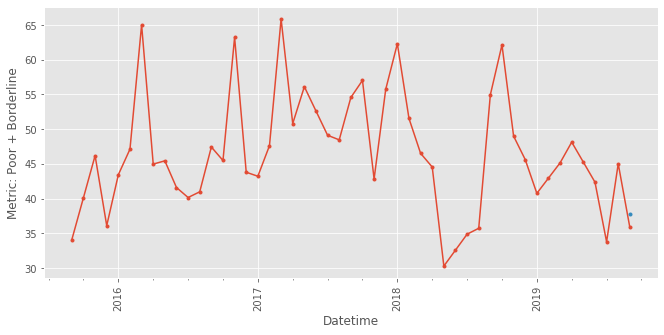

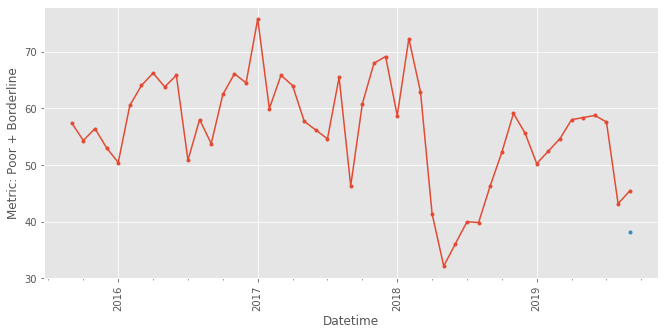

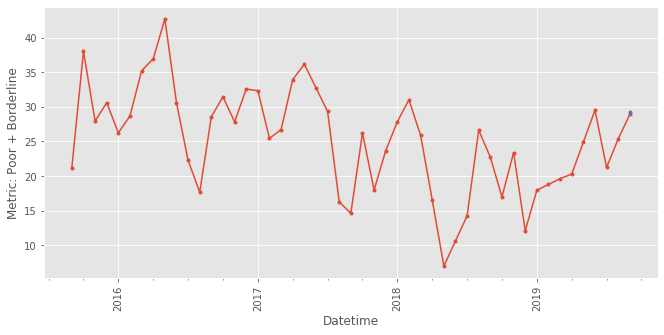

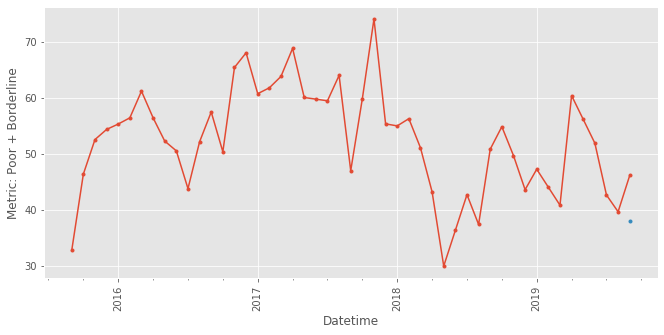

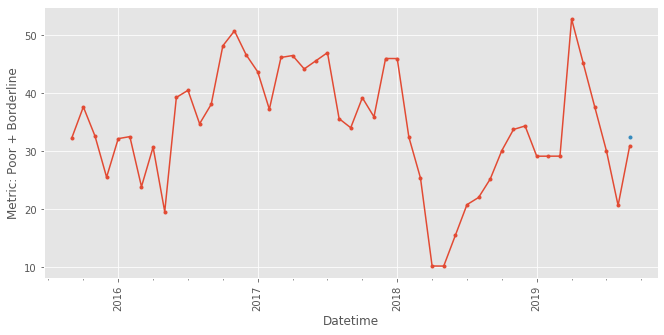

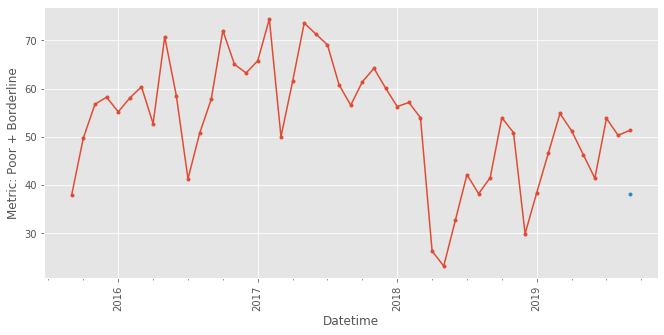

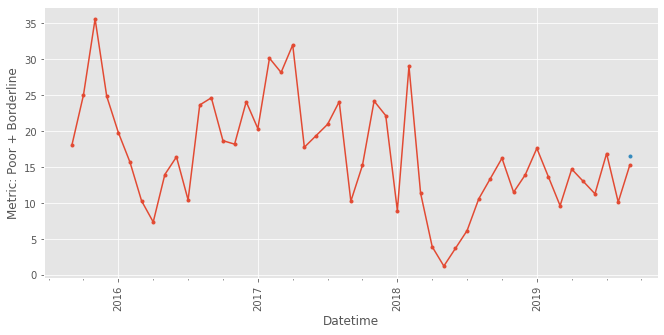

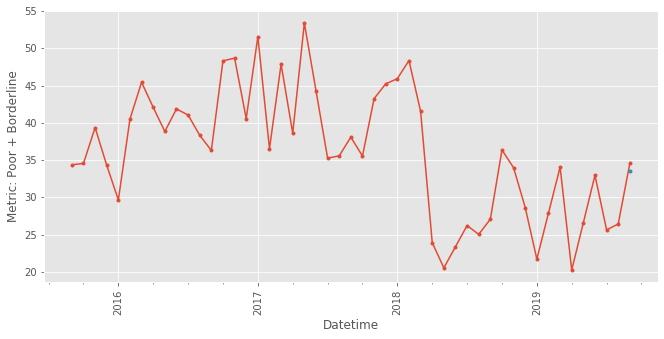

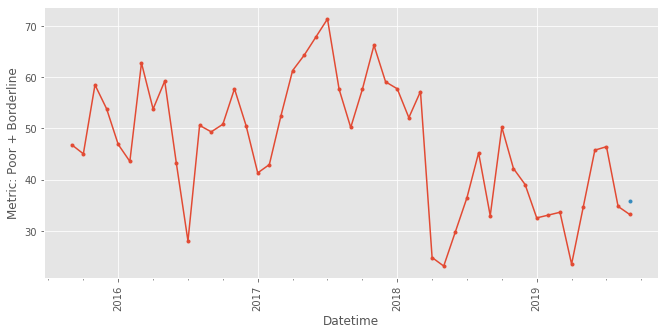

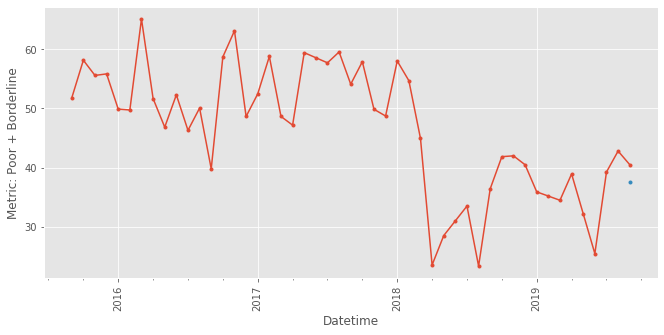

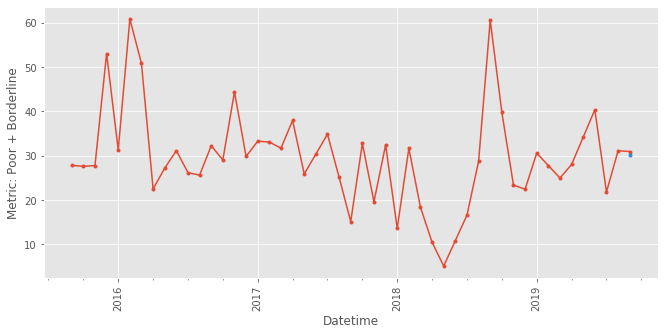

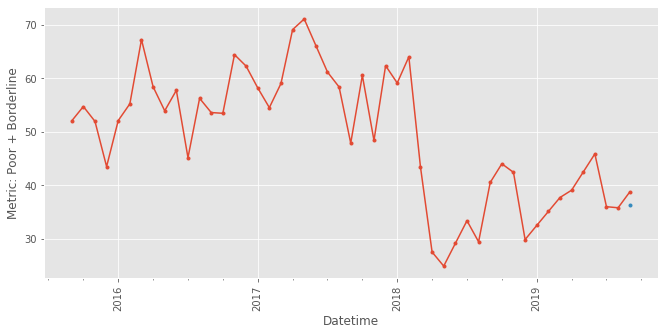

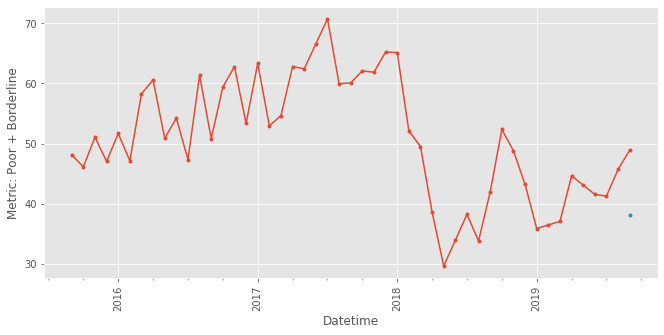

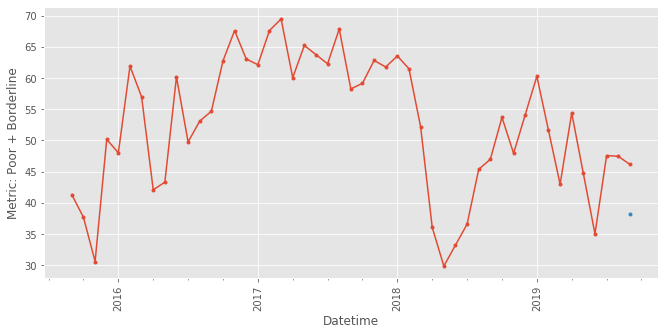

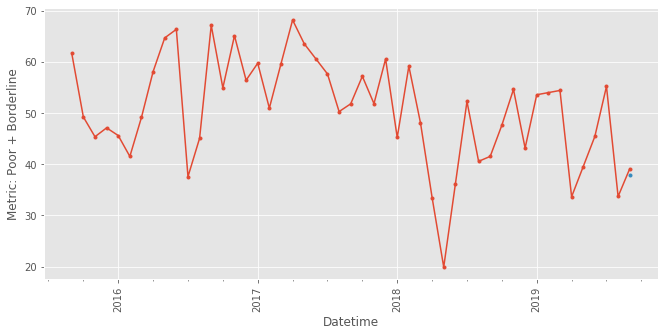

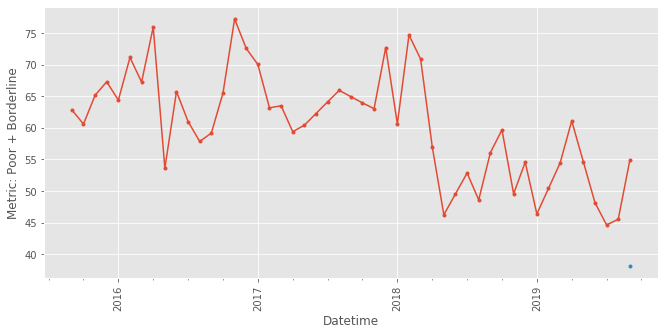

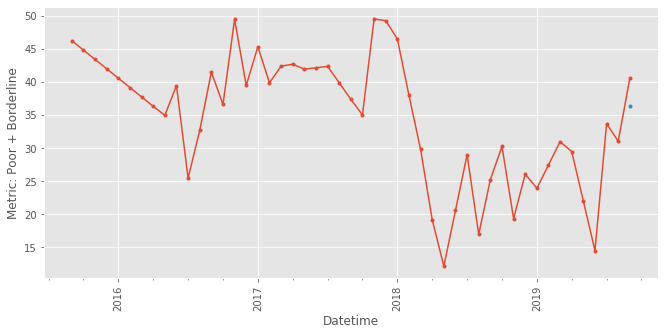

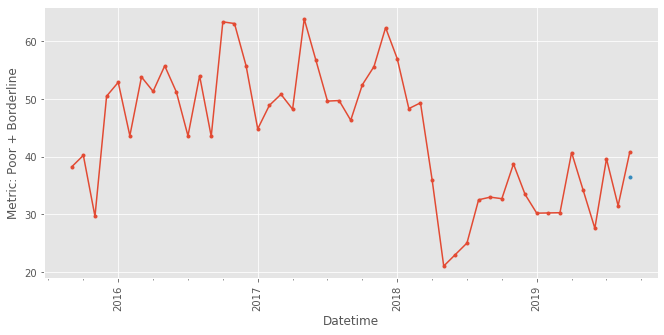

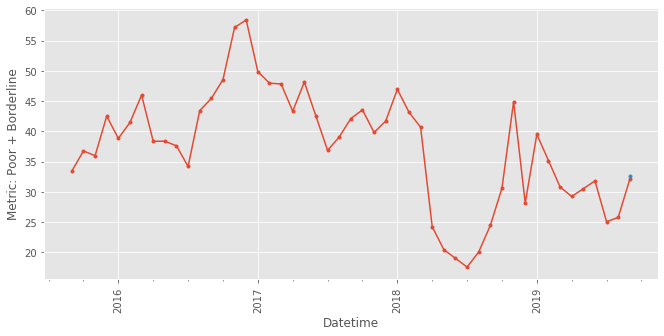

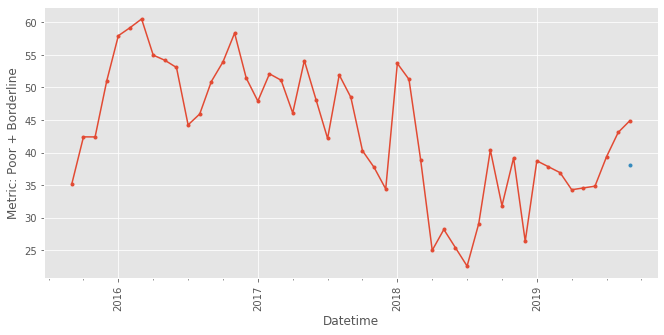

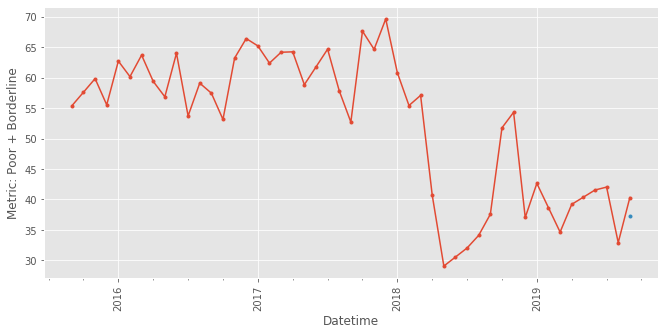

In [114]:
for AdminStrata in fcs_train.columns:
    # Show the time-series to use.
    fig, ax = plt.subplots(figsize = (11, 5))
    fcs[AdminStrata].plot(ax = fig.gca(), style = ".-")
    yhats[AdminStrata].plot(ax = fig.gca(), style = ".-")
    plt.ylabel("Metric: Poor + Borderline")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

# Example 1.5

In [4]:
# Let's define the number of observation we want to predict.
num_predictions = 1
# Let's define the 'train' and 'test' sets.
num_train = len(fcs_rcsi) - num_predictions
fcs_rcsi_train = fcs_rcsi[:num_train]
fcs_rcsi_test = fcs_rcsi[num_train:]
fcs_train = fcs[:num_train]
fcs_test = fcs[num_train:]

print("The number of points used to forecast is:", len(fcs_rcsi_train))
print("The number of points to use for testing the forecast is:", len(fcs_rcsi_test))

The number of points used to forecast is: 48
The number of points to use for testing the forecast is: 1


# Example 2 - Multi-step forecasting FCS indicator

In [5]:
# Let's define the number of observation we want to predict.
num_predictions = 5
# Let's define the 'train' and 'test' sets.
num_train = len(fcs_rcsi) - num_predictions
fcs_rcsi_train = fcs_rcsi[:num_train]
fcs_rcsi_test = fcs_rcsi[num_train:]
fcs_train = fcs[:num_train]
fcs_test = fcs[num_train:]
print("The number of points used to forecast is:", len(fcs_rcsi_train))
print("The number of points to use for testing the forecast is:", len(fcs_rcsi_test))

The number of points used to forecast is: 44
The number of points to use for testing the forecast is: 5


In [6]:
dates_to_forecast = fcs_test.index
dates_to_forecast.array

<DatetimeArray>
['2019-05-31 00:00:00', '2019-06-30 00:00:00', '2019-07-31 00:00:00',
 '2019-08-31 00:00:00', '2019-09-30 00:00:00']
Length: 5, dtype: datetime64[ns]

In [7]:
# Split a multivariate sequence into samples.
n_steps = 3

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
X_tot = list()
y_tot = list()
for AdminStrata in fcs_train.columns:
    # Example for multivariate analysis.
    rcsi_fcs_pairwise = fcs_rcsi_train[["rCSI_" + AdminStrata, "FCS_" + AdminStrata]]
    X, y = split_sequences(rcsi_fcs_pairwise.values, n_steps)
    X_tot.append(X)
    y_tot.append(y)
    
X_tot = np.concatenate(X_tot)
y_tot = np.concatenate(y_tot)

In [128]:
n_features = X_tot.shape[2]
# Define model and perform a preliminary training with all data.
model = Sequential()
model.add(LSTM(100, activation = "relu", return_sequences = True, input_shape = (n_steps, n_features)))
model.add(LSTM(100, activation = "relu"))
model.add(Dense(n_features))
model.compile(optimizer = "adam", loss = "mse")

# Define the checkpoint.
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor = "loss", verbose = 0, save_best_only = True, mode = "min")
callbacks_list = [checkpoint]

# Fit model.
model.fit(X_tot, y_tot, epochs = 100, verbose = 0, batch_size = 32, callbacks = callbacks_list)

In [12]:
def one_step_prediction(ts, i, fcs_rcsi_copy_):
    #X, y = split_sequences(fcs_rcsi[["rCSI_" + ts.name, "FCS_" + ts.name]].values, n_steps)
    # Load the model.
    K.clear_session()
    print(ts.name)
    new_model = load_model("model.h5")
    #new_model.fit(X, y, epochs = 1, verbose = 0, batch_size = 32)
    # Demonstrate prediction.
    x_input = fcs_rcsi_copy_[["rCSI_" + ts.name, "FCS_" + ts.name]].values[-n_steps:]
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = new_model.predict(x_input, verbose = 0).flatten()
    #yhat = pd.Series(yhat[0], index = [dates_to_forecast[0]], name = ts.name)
    return pd.Series(yhat[0], index = [dates_to_forecast[i]], name = "rCSI_" + ts.name), pd.Series(yhat[1], index = [dates_to_forecast[i]], name = "FCS_" + ts.name) 

In [13]:
fcs_rcsi_copy = fcs_rcsi.copy()
for i in range(num_predictions):
    yhats = fcs_train.apply(one_step_prediction, args = [i, fcs_rcsi_copy])
    df = pd.DataFrame([], columns = fcs_rcsi_copy.columns)
    for AdminStrata in fcs_train.columns:
        df["rCSI_" + AdminStrata] = yhats[AdminStrata][0]
        df["FCS_" + AdminStrata] = yhats[AdminStrata][1]
    fcs_rcsi_copy = fcs_rcsi_copy.append(df)

Abyan
Ad Dali
Aden
Al Bayda
Al Hudaydah
Al Jawf
Al Maharah
Al Mahwit
Amran
Dhamar
Hadramaut
Hajjah
Ibb
Lahj
Marib
Raymah
Sa'dah
Sana'a
Sana'a City
Shabwah
Taizz
Abyan
Ad Dali
Aden
Al Bayda
Al Hudaydah
Al Jawf
Al Maharah
Al Mahwit
Amran
Dhamar
Hadramaut
Hajjah
Ibb
Lahj
Marib
Raymah
Sa'dah
Sana'a
Sana'a City
Shabwah
Taizz
Abyan
Ad Dali
Aden
Al Bayda
Al Hudaydah
Al Jawf
Al Maharah
Al Mahwit
Amran
Dhamar
Hadramaut
Hajjah
Ibb
Lahj
Marib
Raymah
Sa'dah
Sana'a
Sana'a City
Shabwah
Taizz
Abyan
Ad Dali
Aden
Al Bayda
Al Hudaydah
Al Jawf
Al Maharah
Al Mahwit
Amran
Dhamar
Hadramaut
Hajjah
Ibb
Lahj
Marib
Raymah
Sa'dah
Sana'a
Sana'a City
Shabwah
Taizz
Abyan
Ad Dali
Aden
Al Bayda
Al Hudaydah
Al Jawf
Al Maharah
Al Mahwit
Amran
Dhamar
Hadramaut
Hajjah
Ibb
Lahj
Marib
Raymah
Sa'dah
Sana'a
Sana'a City
Shabwah
Taizz


In [14]:
d = fcs_rcsi_copy.filter(regex = "FCS_", axis = 1)
d.tail()

AdminStrata,FCS_Abyan,FCS_Ad Dali,FCS_Aden,FCS_Al Bayda,FCS_Al Hudaydah,FCS_Al Jawf,FCS_Al Maharah,FCS_Al Mahwit,FCS_Amran,FCS_Dhamar,...,FCS_Hajjah,FCS_Ibb,FCS_Lahj,FCS_Marib,FCS_Raymah,FCS_Sa'dah,FCS_Sana'a,FCS_Sana'a City,FCS_Shabwah,FCS_Taizz
2019-05-31,37.842556,44.934467,28.237551,42.937523,31.156395,47.925781,15.092639,32.082470,30.755238,39.223866,...,37.179897,45.266102,44.220406,41.053650,49.277134,37.469154,38.976910,31.598518,43.826290,39.446121
2019-06-30,37.823650,43.498085,28.900974,42.741478,28.603569,45.452240,13.979577,31.147842,30.554544,37.538635,...,36.228054,43.269825,43.276775,39.186607,46.815445,36.602909,36.077236,31.182245,44.220093,38.073570
2019-07-31,38.448887,42.682018,30.171530,41.955647,30.191341,43.497971,13.911160,31.144110,30.909109,36.839935,...,34.724030,41.715721,43.449551,38.210033,45.820232,38.039856,34.696278,32.493637,43.117603,37.877956
2019-08-31,39.328060,42.103703,30.766644,41.339268,31.334070,41.866810,13.987228,32.530666,32.116592,37.030506,...,34.169765,40.688873,42.889046,38.418766,43.853500,38.524067,34.093033,33.178268,42.862400,38.592506
2019-09-30,39.882164,41.549706,31.333189,40.992481,31.607027,40.839485,13.537961,32.942501,32.714211,37.047333,...,34.050365,39.943241,42.616547,38.335953,42.605076,38.794899,35.131680,33.402561,42.588627,38.559204


In [15]:
d.columns = d.columns.str.replace("FCS_", '')

In [16]:
fcs_rcsi_copy.tail()

AdminStrata,FCS_Abyan,FCS_Ad Dali,FCS_Aden,FCS_Al Bayda,FCS_Al Hudaydah,FCS_Al Jawf,FCS_Al Maharah,FCS_Al Mahwit,FCS_Amran,FCS_Dhamar,...,rCSI_Hajjah,rCSI_Ibb,rCSI_Lahj,rCSI_Marib,rCSI_Raymah,rCSI_Sa'dah,rCSI_Sana'a,rCSI_Sana'a City,rCSI_Shabwah,rCSI_Taizz
2019-05-31,37.842556,44.934467,28.237551,42.937523,31.156395,47.925781,15.092639,32.082470,30.755238,39.223866,...,93.736740,90.330559,84.911369,89.248077,89.285469,83.065460,90.160934,89.169281,85.085121,86.208954
2019-06-30,37.823650,43.498085,28.900974,42.741478,28.603569,45.452240,13.979577,31.147842,30.554544,37.538635,...,94.076942,90.152466,85.055222,88.995796,89.063095,84.314941,90.554565,88.927536,84.693649,87.020142
2019-07-31,38.448887,42.682018,30.171530,41.955647,30.191341,43.497971,13.911160,31.144110,30.909109,36.839935,...,92.521309,89.306961,84.559685,89.570000,87.479561,84.330307,90.247673,89.408600,85.325989,87.880920
2019-08-31,39.328060,42.103703,30.766644,41.339268,31.334070,41.866810,13.987228,32.530666,32.116592,37.030506,...,92.346779,89.191193,84.962708,89.042297,87.130165,84.594643,89.421814,89.028969,85.359184,87.306648
2019-09-30,39.882164,41.549706,31.333189,40.992481,31.607027,40.839485,13.537961,32.942501,32.714211,37.047333,...,92.000664,89.044373,85.251160,88.749176,87.097733,85.057762,89.547859,88.897789,85.357193,87.306847


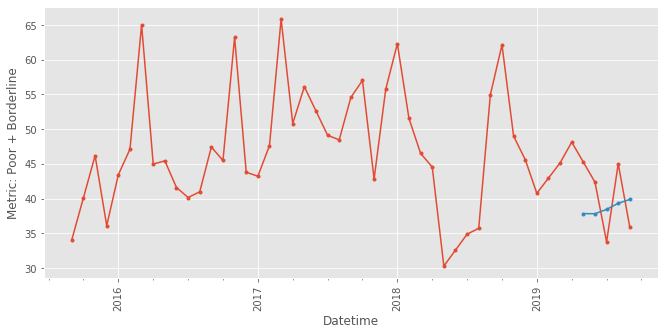

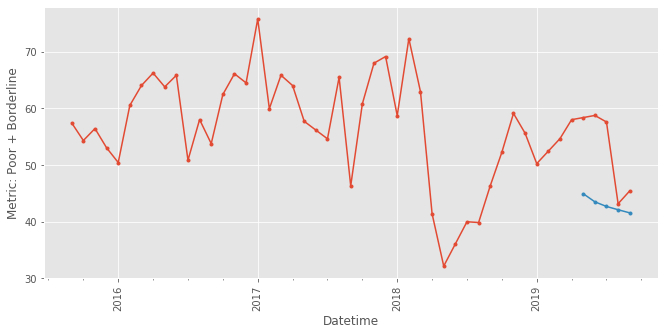

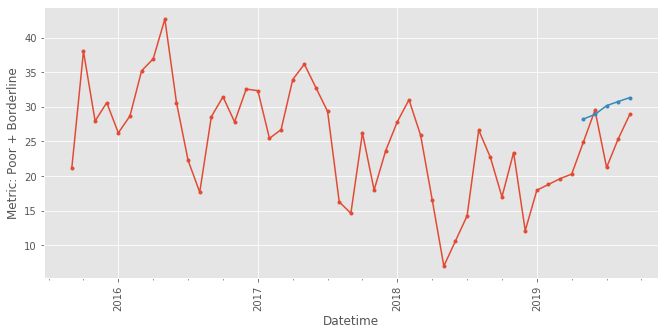

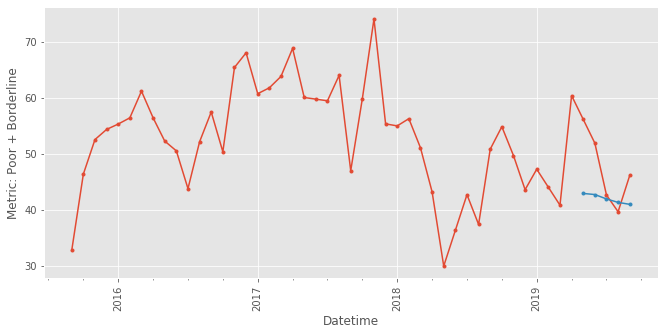

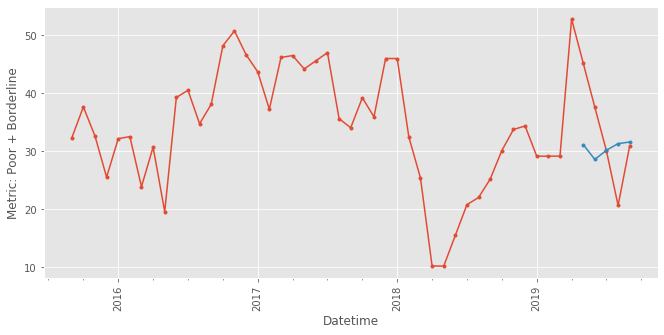

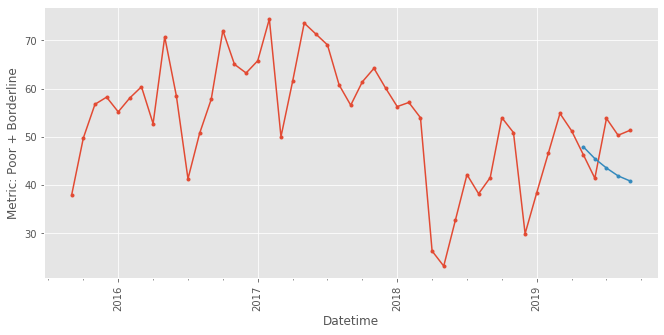

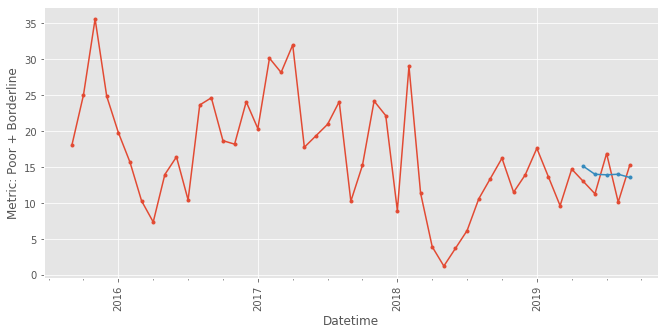

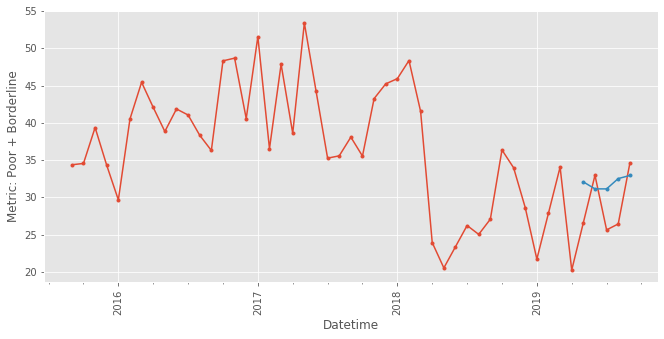

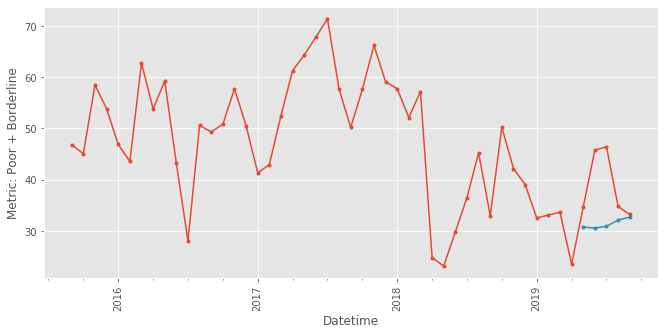

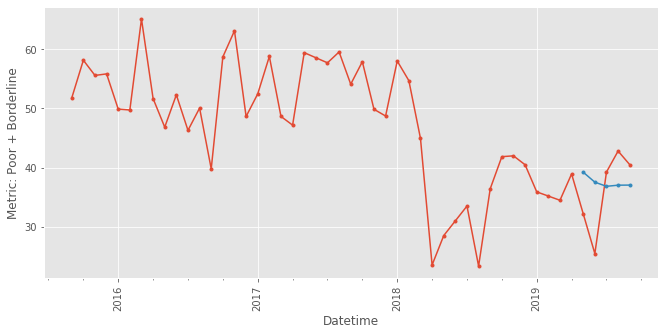

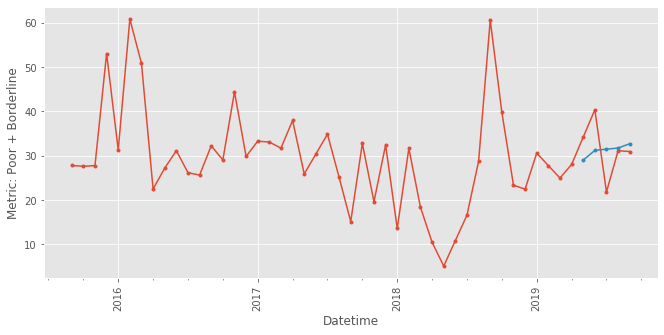

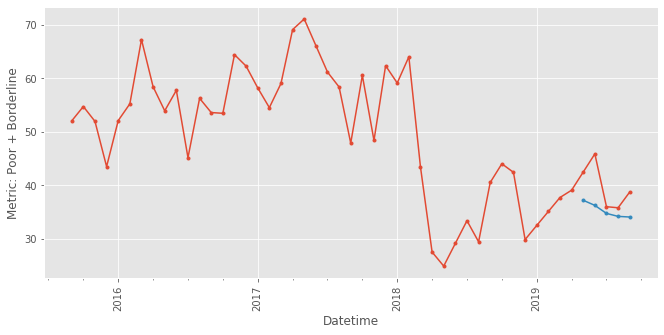

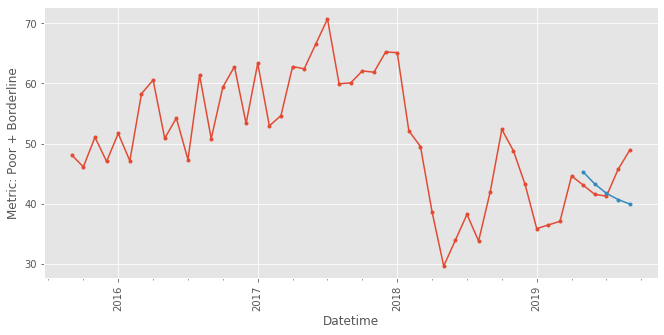

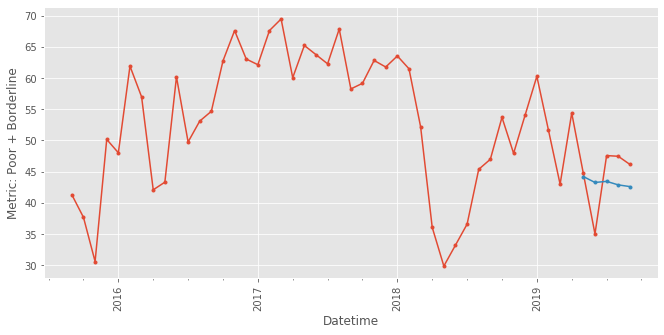

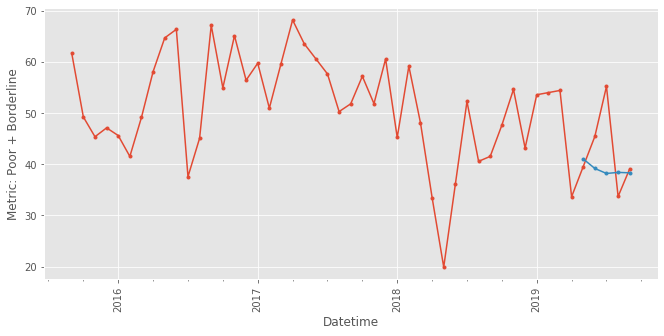

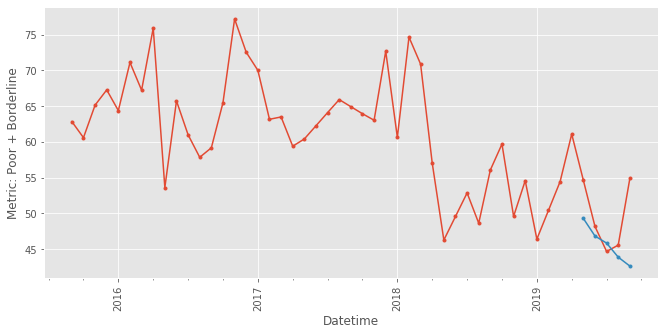

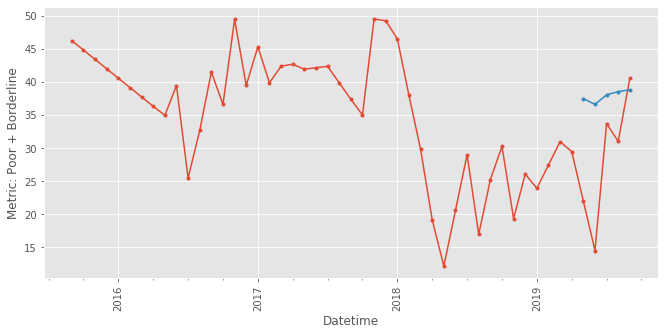

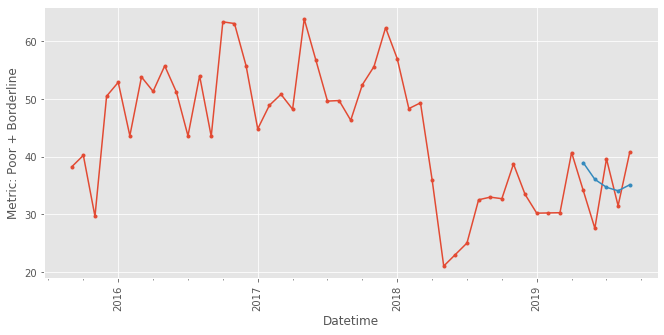

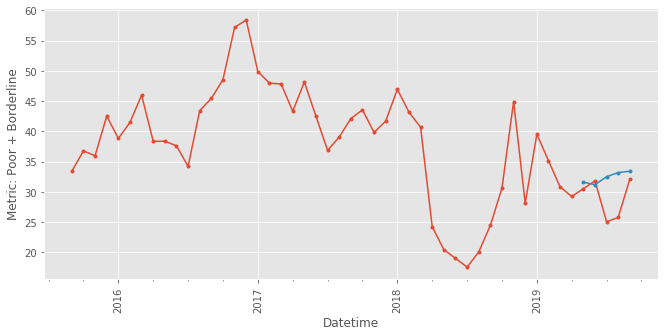

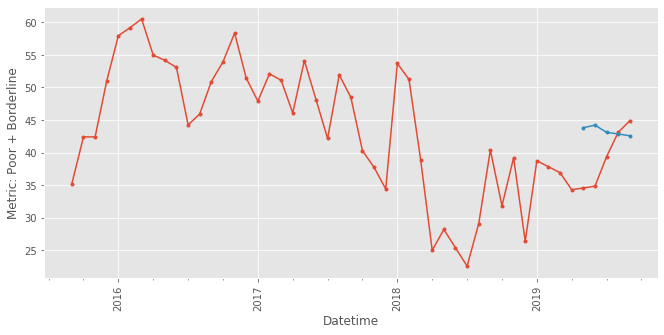

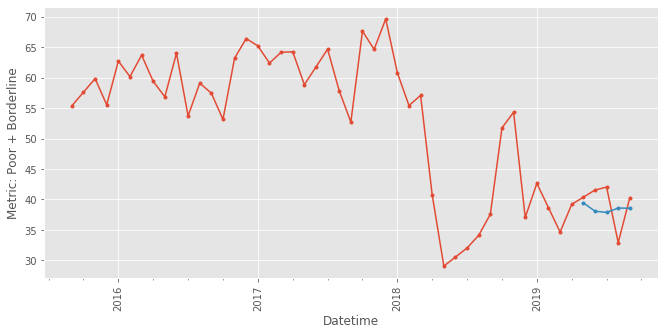

In [19]:
for AdminStrata in fcs_train.columns:
    # Show the time-series to use.
    fig, ax = plt.subplots(figsize = (11, 5))
    fcs[AdminStrata].plot(ax = fig.gca(), style = ".-")
    d[-num_predictions:][AdminStrata].plot(ax = fig.gca(), style = ".-")
    plt.ylabel("Metric: Poor + Borderline")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

In [30]:
def error(y_hat, y_true):
    error = np.sqrt(mean_squared_error(y_true = y_true[y_hat.name].values, 
                                       y_pred = y_hat.values))
    return error
    
d[-num_predictions:].apply(error, args = [fcs[-num_predictions:]]).mean()

6.63571678285917

In [ ]:
y_true[y_hat.name]

In [23]:
fcs[-num_predictions:]

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-05-31,45.25,58.385,24.895,56.165,45.22,46.305,12.985,26.61,34.645,32.20,...,42.465,43.08,44.715,39.555,54.625,21.96,34.16,30.515,34.575,40.375
2019-06-30,42.37,58.760,29.510,51.920,37.60,41.380,11.270,32.97,45.770,25.47,...,45.860,41.54,35.040,45.450,48.160,14.47,27.59,31.800,34.850,41.550
2019-07-31,33.78,57.600,21.240,42.660,30.05,53.800,16.870,25.64,46.440,39.25,...,35.980,41.26,47.580,55.210,44.650,33.68,39.64,25.050,39.390,42.030
2019-08-31,45.02,43.160,25.370,39.670,20.66,50.300,10.120,26.44,34.780,42.80,...,35.780,45.70,47.470,33.710,45.540,31.01,31.50,25.770,43.110,32.920
2019-09-30,35.85,45.430,28.920,46.150,30.97,51.310,15.280,34.58,33.210,40.50,...,38.730,48.89,46.170,39.130,54.870,40.56,40.76,32.100,44.900,40.310


In [ ]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps,n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs = 100, verbose = 1, batch_size=32)
#
model.fit(X1, y1, epochs = 1000, verbose = 0, batch_size=32)
# demonstrate prediction
x_input = df_train[["rCSI_Aden", "FCS_Aden"]].values[-n_steps:]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
#inversed = scaler.inverse_transform(yhat)
print(yhat)

In [ ]:
X1, y1 = split_sequences(fcs_rcsi[["rCSI_Aden", "FCS_Aden"]].values, n_steps)

In [192]:
# Example for multivariate analysis.
df = fcs_rcsi[["rCSI_Aden", "rCSI_Amran", "rCSI_Al Hudaydah", "FCS_Aden"]]
df.head(n = 10)

AdminStrata,rCSI_Aden,rCSI_Amran,rCSI_Al Hudaydah,FCS_Aden
Datetime,,,,
2015-09-30,79.15,80.29,83.10,21.22
2015-10-31,69.58,81.04,91.68,38.02
2015-11-30,73.95,84.95,82.87,27.95
2015-12-31,69.99,82.13,81.43,30.60
2016-01-31,60.77,79.78,77.47,26.24
2016-02-29,56.90,82.61,74.91,28.68
2016-03-31,63.39,89.91,77.83,35.21
2016-04-30,77.23,92.35,73.38,36.94
2016-05-31,65.59,93.02,75.63,42.70


In [203]:
num_predictions = 10
# Let's define the 'train' and 'test' sets.
num_train = len(df) - num_predictions
df_train = df[:num_train]
df_test = df[num_train:]

In [179]:
df_train.tail()

AdminStrata,rCSI_Aden,rCSI_Amran,rCSI_Al Hudaydah,FCS_Aden
Datetime,,,,
2018-07-31,73.56,94.50,91.19,14.24
2018-08-31,80.46,90.23,87.97,26.63
2018-09-30,89.06,81.56,87.35,22.70
2018-10-31,91.57,96.99,90.90,16.98
2018-11-30,81.96,87.67,85.56,23.39


In [180]:
df_test

AdminStrata,rCSI_Aden,rCSI_Amran,rCSI_Al Hudaydah,FCS_Aden
Datetime,,,,
2018-12-31,80.820,95.030,92.29,12.100
2019-01-31,88.350,87.380,87.98,17.940
2019-02-28,84.670,88.525,88.09,18.780
2019-03-31,80.990,89.670,88.20,19.620
2019-04-30,72.770,95.320,96.03,20.280
2019-05-31,78.315,93.290,91.15,24.895
2019-06-30,83.860,91.260,86.27,29.510
2019-07-31,77.900,95.170,81.35,21.240
2019-08-31,77.750,93.340,91.76,25.370


In [194]:
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler

In [195]:
#values = df_train.values#df_train.values.reshape((df_train.shape[0]*df_train.shape[1], 1))

In [196]:
#scaler = StandardScaler()#MinMaxScaler(feature_range=(0, 1))
#scaler = scaler.fit(values)

In [197]:
#normalized = scaler.transform(df_train.values)
#print(normalized)

In [198]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [199]:
n_steps = 3

In [210]:
X, y = split_sequences(normalized, n_steps)
X[-1]

array([[ 0.67833753,  0.32960902,  0.14477728,  0.07150668],
       [ 1.71995092, -1.51133412,  0.02941348, -0.43123774],
       [ 2.02395669,  1.7649926 ,  0.68996431, -1.16296752]])

# PROVA

In [217]:
df = fcs_rcsi.copy()
num_predictions = 10
# Let's define the 'train' and 'test' sets.
num_train = len(df) - num_predictions
df_train = df[:num_train]
df_test = df[num_train:]

In [218]:
X_fin = []
y_fin = []
for AdminStrata in fcs.columns:
    # Example for multivariate analysis.
    data = df_train[["rCSI_" + AdminStrata, "FCS_" + AdminStrata]]
    X, y = split_sequences(data.values, n_steps)
    X_fin.append(X)
    y_fin.append(y)

In [220]:
X = np.concatenate(X_fin)
y = np.concatenate(y_fin)

In [221]:
X1, y1 = split_sequences(fcs_rcsi[["rCSI_Aden", "FCS_Aden"]].values, n_steps)

In [229]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps,n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs = 100, verbose = 1, batch_size=32)
#
model.fit(X1, y1, epochs = 1000, verbose = 0, batch_size=32)
# demonstrate prediction
x_input = df_train[["rCSI_Aden", "FCS_Aden"]].values[-n_steps:]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
#inversed = scaler.inverse_transform(yhat)
print(yhat)

Epoch 1/100
756/756 [==============================] - ETA: 2:54 - loss: 2282.58 - ETA: 53s - loss: 2132.0361 - ETA: 23s - loss: 2042.329 - ETA: 12s - loss: 1978.724 - ETA: 7s - loss: 1957.996 - ETA: 4s - loss: 1871.13 - ETA: 2s - loss: 1711.21 - ETA: 1s - loss: 1543.90 - 8s 11ms/step - loss: 1393.0706
Epoch 2/100
756/756 [==============================] - ETA: 0s - loss: 124.102 - ETA: 0s - loss: 193.796 - ETA: 0s - loss: 237.957 - ETA: 0s - loss: 213.476 - ETA: 0s - loss: 186.623 - ETA: 0s - loss: 176.998 - ETA: 0s - loss: 169.248 - ETA: 0s - loss: 160.099 - 1s 701us/step - loss: 152.4614
Epoch 3/100
756/756 [==============================] - ETA: 0s - loss: 91.51 - ETA: 0s - loss: 99.22 - ETA: 0s - loss: 94.76 - ETA: 0s - loss: 86.59 - ETA: 0s - loss: 82.05 - ETA: 0s - loss: 78.44 - ETA: 0s - loss: 83.39 - ETA: 0s - loss: 86.71 - 1s 676us/step - loss: 85.1017
Epoch 4/100
756/756 [==============================] - ETA: 0s - loss: 74.96 - ETA: 0s - loss: 74.86 - ETA: 0s - loss: 79.34 

756/756 [==============================] - ETA: 0s - loss: 42.14 - ETA: 0s - loss: 46.14 - ETA: 0s - loss: 48.14 - ETA: 0s - loss: 59.59 - ETA: 0s - loss: 60.44 - ETA: 0s - loss: 63.29 - ETA: 0s - loss: 63.98 - ETA: 0s - loss: 61.58 - ETA: 0s - loss: 61.34 - ETA: 0s - loss: 60.09 - 1s 877us/step - loss: 61.5148
Epoch 53/100
756/756 [==============================] - ETA: 0s - loss: 59.05 - ETA: 0s - loss: 68.16 - ETA: 0s - loss: 65.25 - ETA: 0s - loss: 66.31 - ETA: 0s - loss: 63.27 - ETA: 0s - loss: 64.59 - ETA: 0s - loss: 63.22 - ETA: 0s - loss: 62.42 - ETA: 0s - loss: 61.14 - ETA: 0s - loss: 59.76 - ETA: 0s - loss: 60.66 - 1s 873us/step - loss: 60.2598
Epoch 54/100
756/756 [==============================] - ETA: 0s - loss: 55.70 - ETA: 0s - loss: 58.26 - ETA: 0s - loss: 56.57 - ETA: 0s - loss: 59.13 - ETA: 0s - loss: 58.90 - ETA: 0s - loss: 58.58 - ETA: 0s - loss: 59.12 - ETA: 0s - loss: 59.53 - 1s 731us/step - loss: 60.0047
Epoch 55/100
756/756 [==============================] - ETA

In [227]:
df_train[["rCSI_Aden", "FCS_Aden"]].values[-n_steps:]

array([[89.06, 22.7 ],
       [91.57, 16.98],
       [81.96, 23.39]])

In [120]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = df_train[-n_steps:].values
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[23.460155]]
